In [1]:
# Import necessary libraries
import os
from model_config import *
from preprocess import *
from train import *
from utils import *
from inference import *
from torch.optim import AdamW
from loss import *
from data_visualization import *

# Define paths for the dataset
image_folder = "data/Huron_data/Sliced_Images"
mask_folder = "data/Huron_data/Sliced_Masks"

# Ensure the dataset folders exist
assert os.path.exists(image_folder), "Image folder not found!"
assert os.path.exists(mask_folder), "Mask folder not found!"

In [2]:
# Specify the pre-trained model name
pretrained_model_name = "facebook/mask2former-swin-base-IN21k-ade-semantic"

# Load the image processor
image_processor = load_image_processor(
    pretrained_model_name=pretrained_model_name,
    do_rescale=True,
    do_normalize=False,  # Set to False for binary segmentation
    do_resize=True
)

# Load the Mask2Former model with binary segmentation setup
model = load_mask2former_model(
    pretrained_model_name=pretrained_model_name,
    num_labels=2,  # Binary segmentation (e.g., background and tissue)
    ignore_mismatched_sizes=True,
    freeze_encoder=True
)

# Print trainable layers for verification
print_trainable_layers(model)

/Users/brandonleblanc/anaconda3/lib/python3.12/site-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)
Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-IN21k-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.weight is frozen
model.pixel_level_module.encoder.embeddings.patch_embeddings.projection.bias is frozen
model.pixel_level_module.encoder.embeddings.norm.weight is frozen
model.pixel_level_module.encoder.embeddings.norm.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.layernorm_before.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.query.bias is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.weight is frozen
model.pixel_level_module.encoder.encoder.layers.0.blocks.0.attention.self.key.bias is frozen
model.pixel_level

In [3]:

# Create DataLoaders for training and validation
train_loader, val_loader,dataset, image_files, mask_files = create_dataloaders(
    image_folder=image_folder,
    mask_folder=mask_folder,
    image_processor=image_processor,
    batch_size=16,
    divide=50 # Size of the dataset 1 = FULL DATaSET (reduce for faster training/testing)
)


# Verify DataLoaders are working correctly
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Number of examples
print(f"Number of training examples: {len(train_loader.dataset)}")
print(f"Number of validation examples: {len(val_loader.dataset)}")


Number of training batches: 18
Number of validation batches: 5
Number of training examples: 276
Number of validation examples: 70


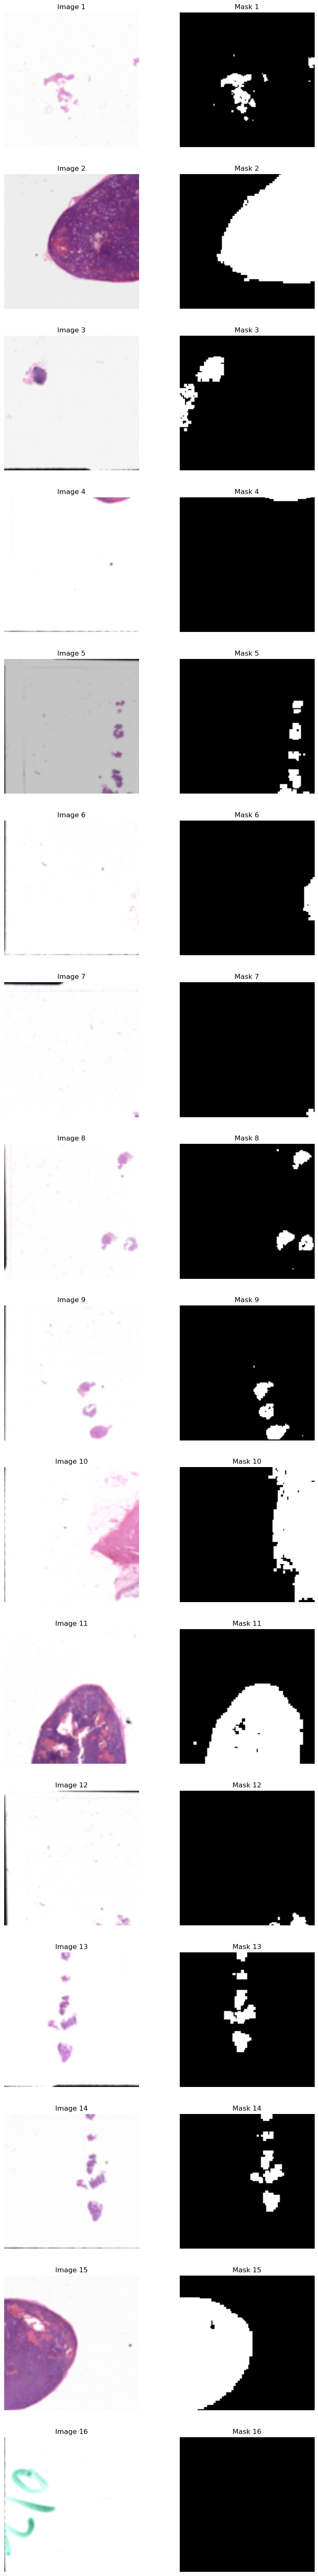

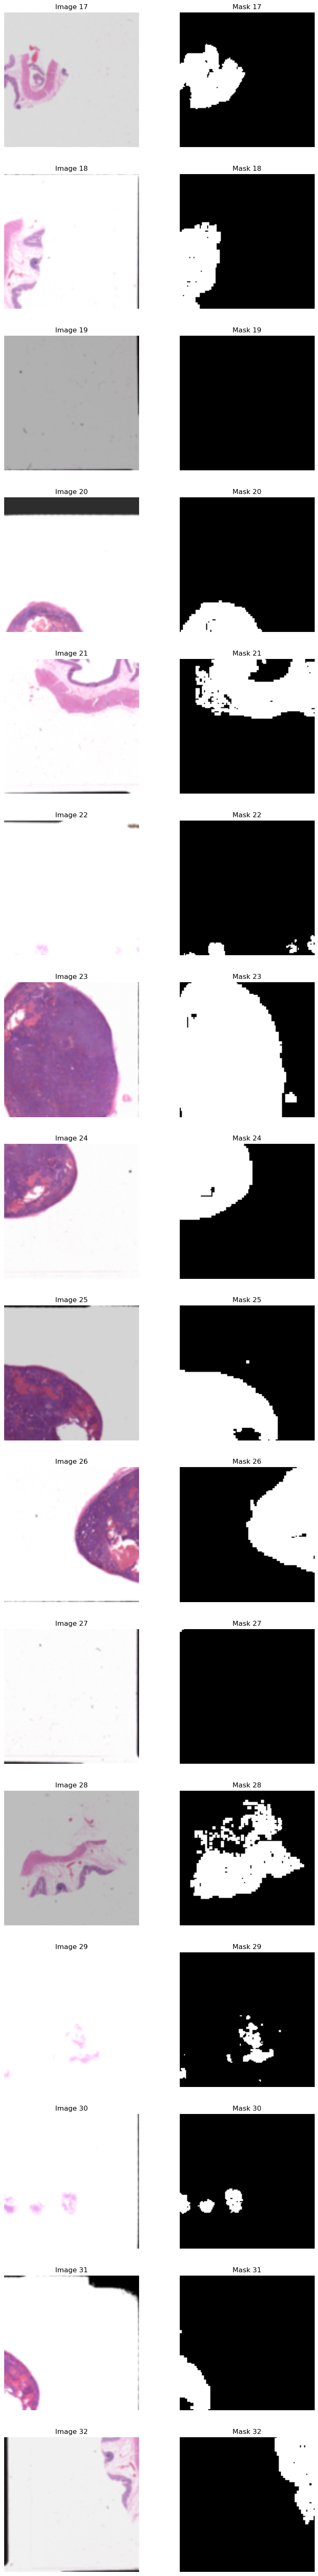

In [4]:
# Visualize batches from the train_loader
visualize_batch_from_loader(train_loader, 2)

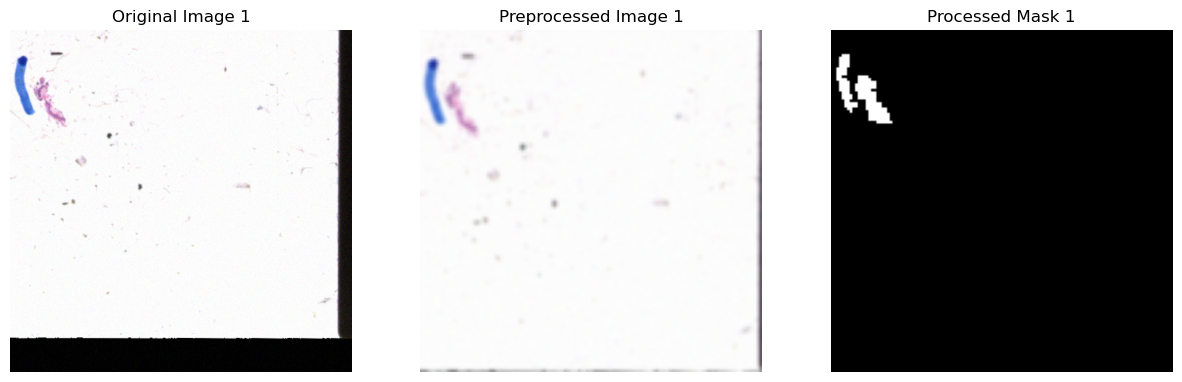

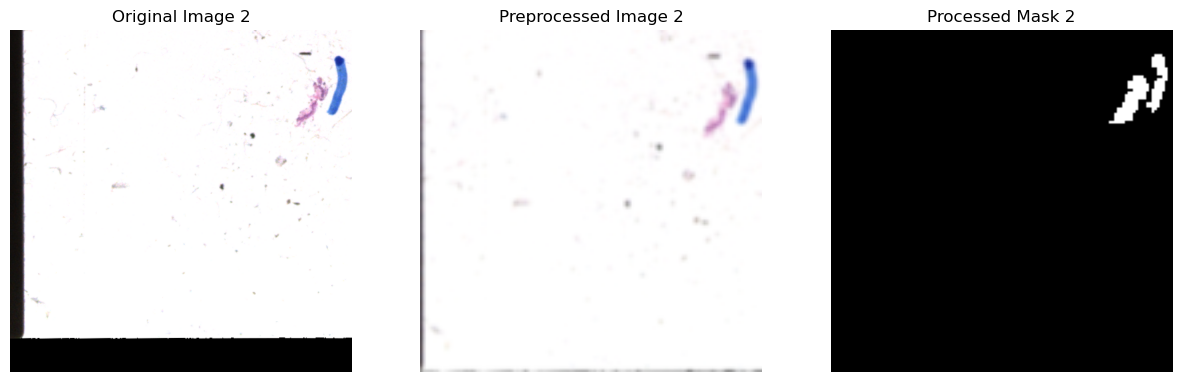

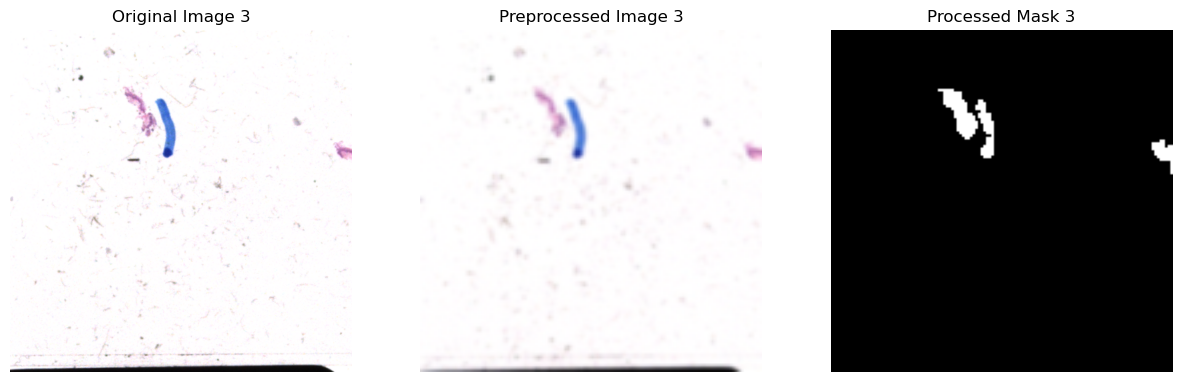

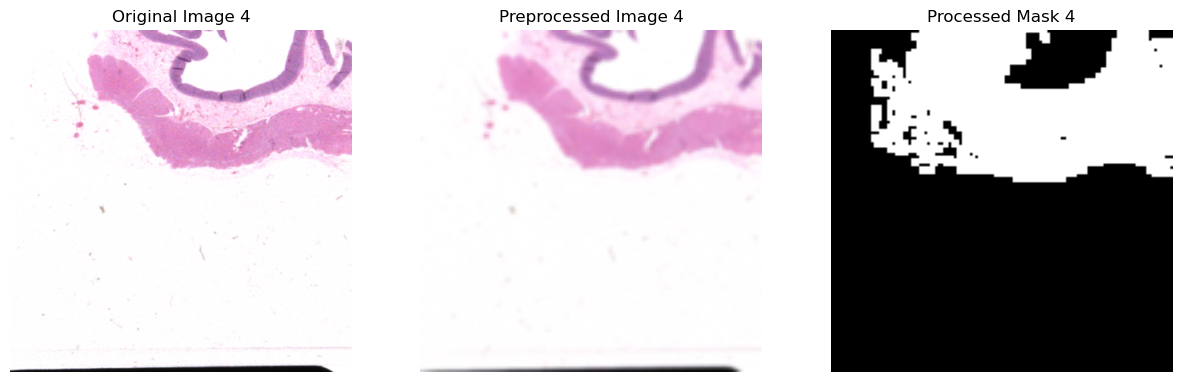

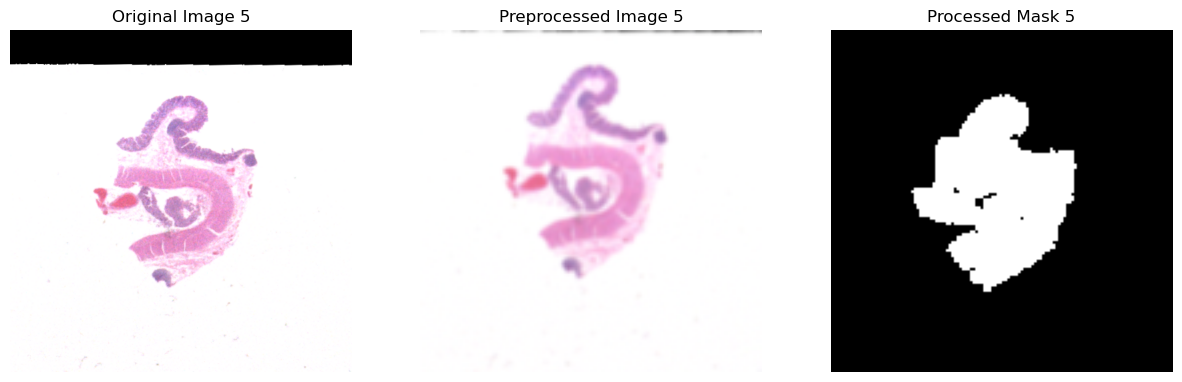

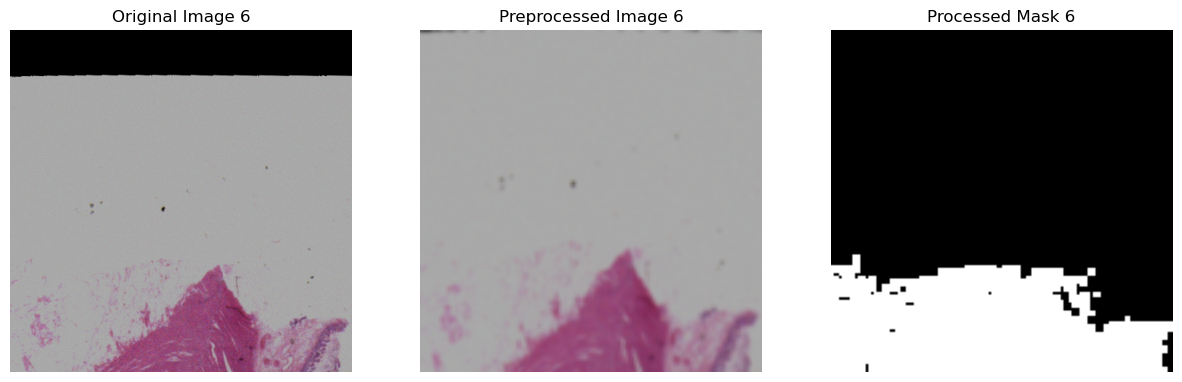

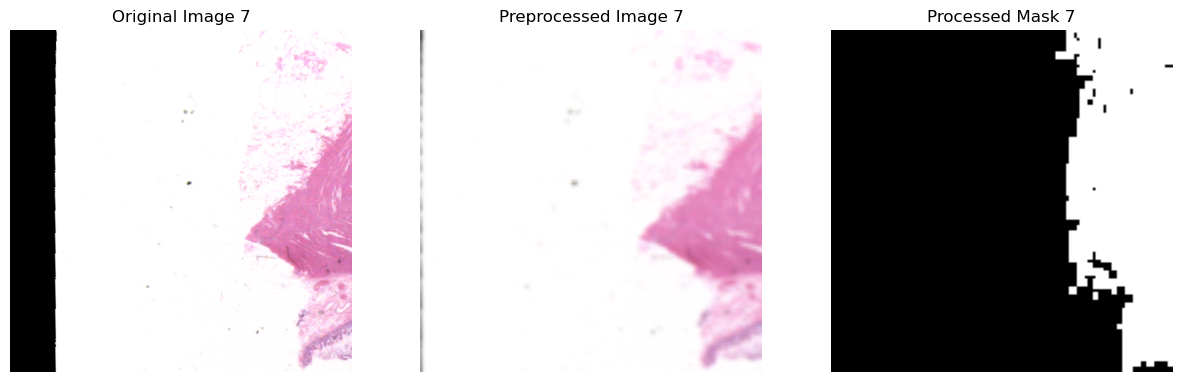

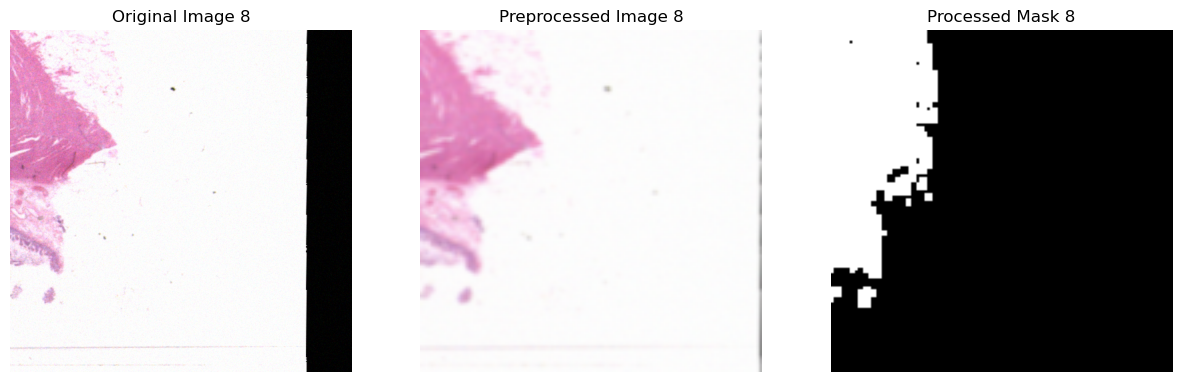

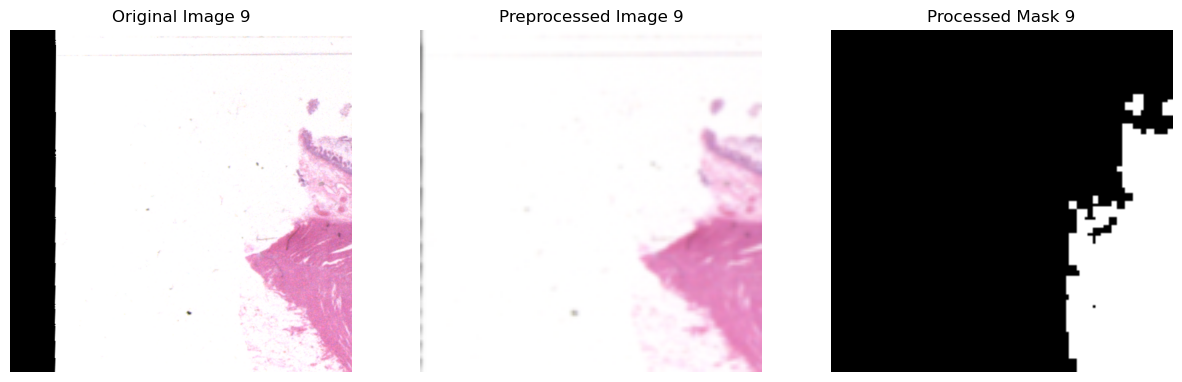

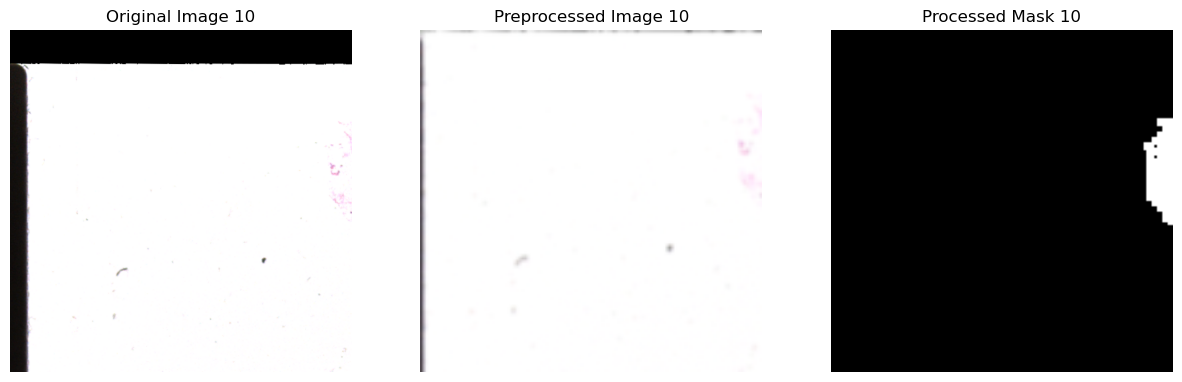

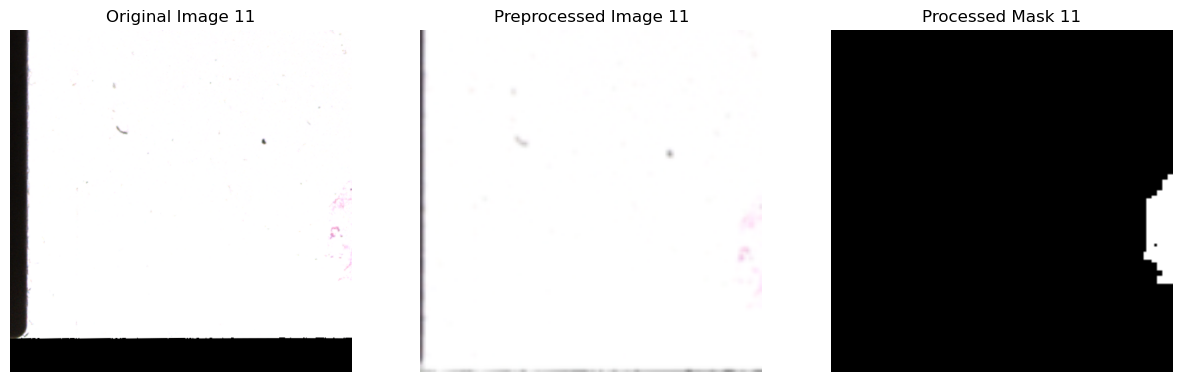

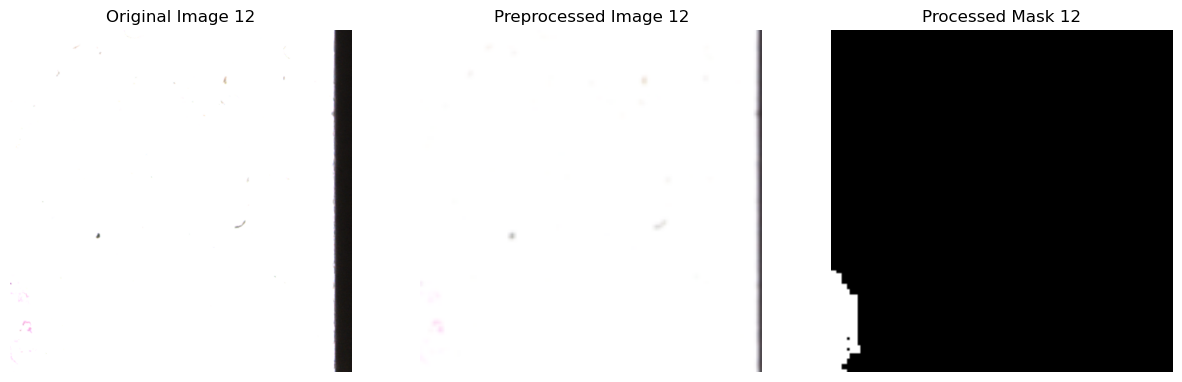

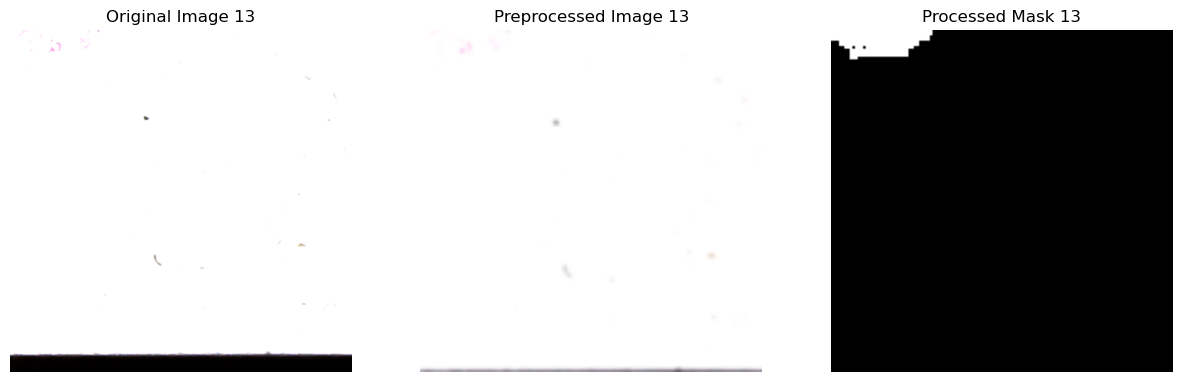

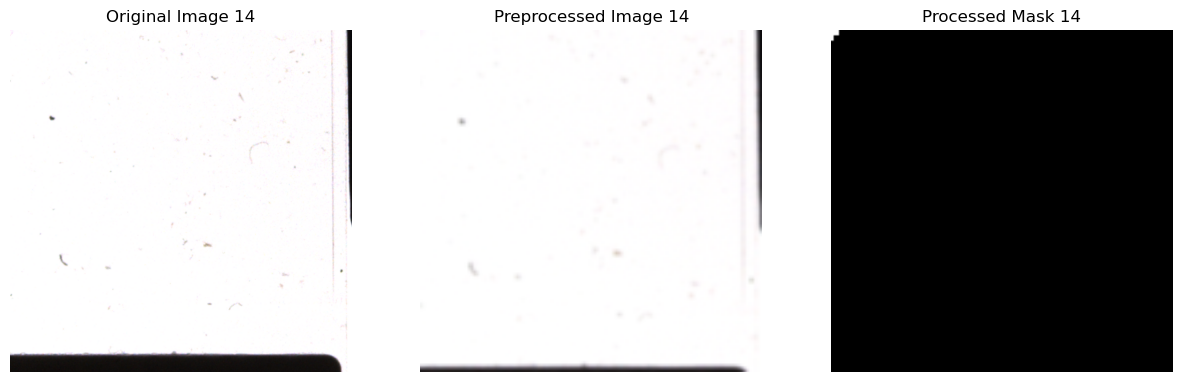

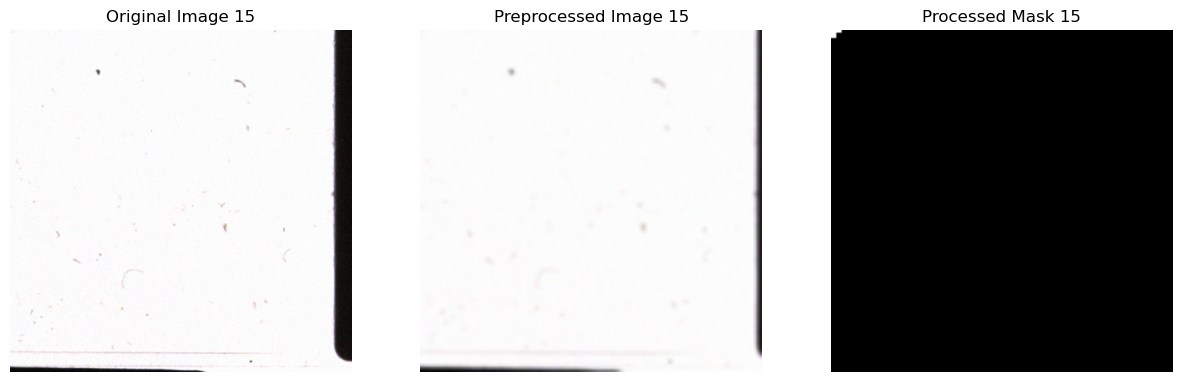

In [5]:
# Verify alignment by visualizing masks, images, and ground truths
verify_data_alignment(dataset,image_files, num_samples=15)

In [6]:
###########################
#   Training the model    #
###########################

# Set the device - Note: without cuda, training on full dataset is VERY impractical 
# On CPU, FUll dataset training will take 2 hours per epoch, while on GPU
# On GPU, Full dataset training will take ~5 to 30 minutes per epoch depending on the GPU
# A100 takes 5 minutes per epoch, while T4 takes 30 minutes per epoch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device to be used
print(f"Device: {device}")

# Define the optimizer - learning rate must be 1e-4 to ensure convergence and reasonable epochs
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Define the loss function - import from loss.py
loss = DiceLoss()

# Define the number of epochs to train (10 for optimal results, 5 for demonstration)
num_epochs = 5

# Train the model - import from train.py
train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=loss,
    num_epochs=num_epochs,
    device=device
)




Device: cpu


Epoch [1/5] Training: 100%|██████████| 18/18 [04:41<00:00, 15.62s/it]


Epoch [1/5], Training Loss: 0.3859


Validation: 100%|██████████| 5/5 [00:38<00:00,  7.67s/it]


Epoch [1/5] Validation - Loss: 0.7150, IoU: 0.5500, Dice: 0.6381



Epoch [2/5] Training: 100%|██████████| 18/18 [04:43<00:00, 15.73s/it]


Epoch [2/5], Training Loss: 0.1840


Validation: 100%|██████████| 5/5 [00:38<00:00,  7.68s/it]


Epoch [2/5] Validation - Loss: 0.7140, IoU: 0.5661, Dice: 0.6575



Epoch [3/5] Training: 100%|██████████| 18/18 [04:43<00:00, 15.72s/it]


Epoch [3/5], Training Loss: 0.1382


Validation: 100%|██████████| 5/5 [00:39<00:00,  7.95s/it]


Epoch [3/5] Validation - Loss: 0.7118, IoU: 0.6228, Dice: 0.7186



Epoch [4/5] Training: 100%|██████████| 18/18 [04:54<00:00, 16.38s/it]


Epoch [4/5], Training Loss: 0.1339


Validation: 100%|██████████| 5/5 [00:38<00:00,  7.64s/it]


Epoch [4/5] Validation - Loss: 0.7120, IoU: 0.6244, Dice: 0.7220



Epoch [5/5] Training: 100%|██████████| 18/18 [04:39<00:00, 15.53s/it]


Epoch [5/5], Training Loss: 0.1468


Validation: 100%|██████████| 5/5 [00:36<00:00,  7.32s/it]

Epoch [5/5] Validation - Loss: 0.7132, IoU: 0.5926, Dice: 0.6899



In [9]:
# Save the model and Load the model for inferencing

# Specify the path to save the model
model_path =  os.getcwd() + "/models/tissue_segmentation_model_example"


# Use utils.py to save the model
save_model_and_processor(model=model, image_processor=image_processor, save_dir=model_path)





Model and image processor saved to /Users/brandonleblanc/Huron-Tissue-Segment/models/tissue_segmentation_model_example
Model and image processor loaded from /Users/brandonleblanc/Huron-Tissue-Segment/models/tissue_segmentation_model_example


In [4]:
# Specify the path to save the model
model_path =  os.getcwd() + "/models/tissue_segmentation_model_example"

# Load the model and processor
model_test, image_processor_test = load_model_and_processor(model_path)


Model and image processor loaded from /Users/brandonleblanc/Huron-Tissue-Segment/models/tissue_segmentation_model_example


Device: cpu


Inferencing:   0%|          | 0/5 [00:00<?, ?it/s]

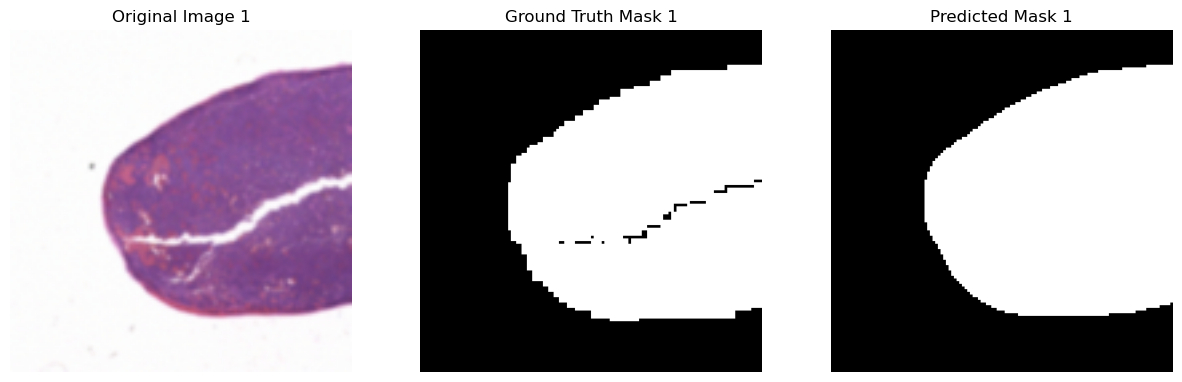

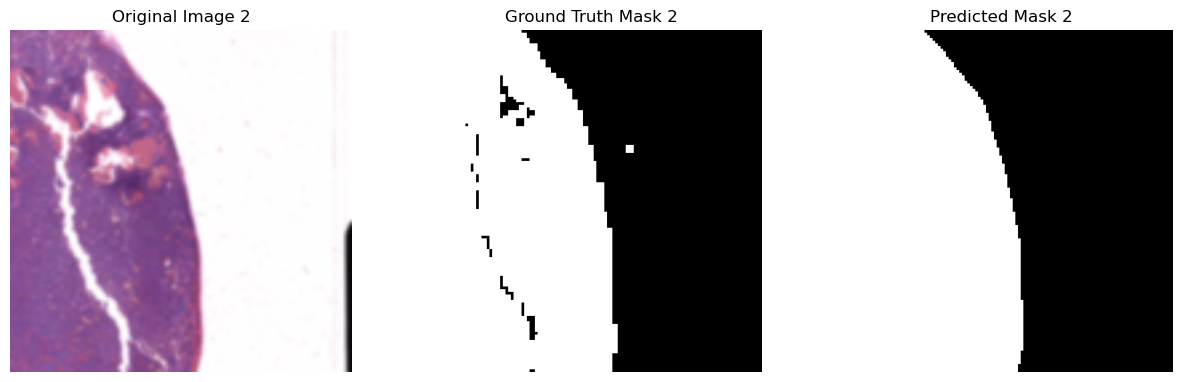

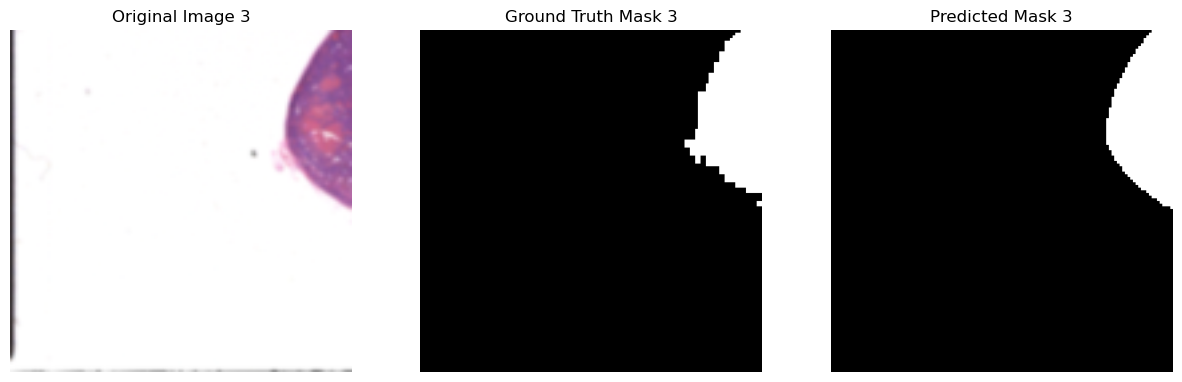

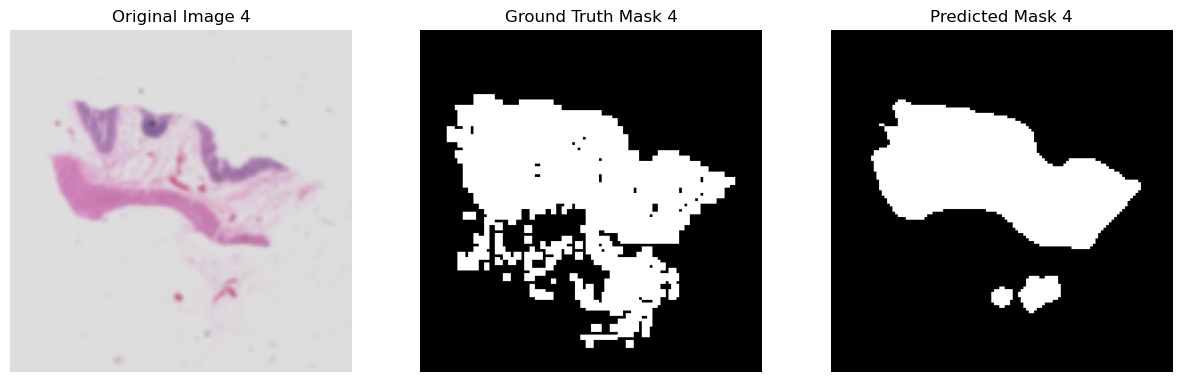

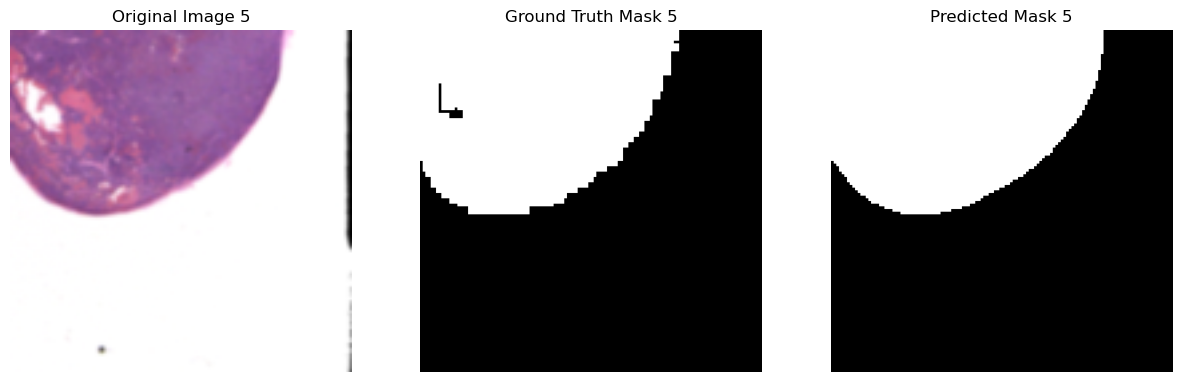

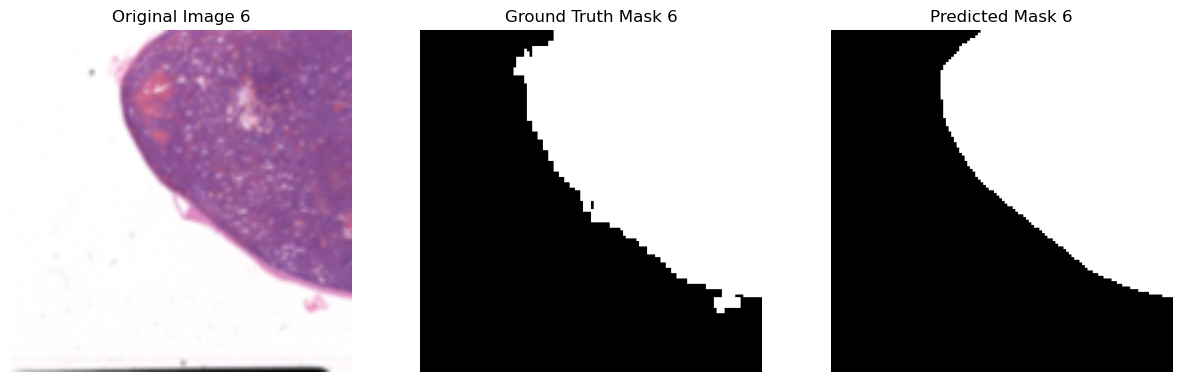

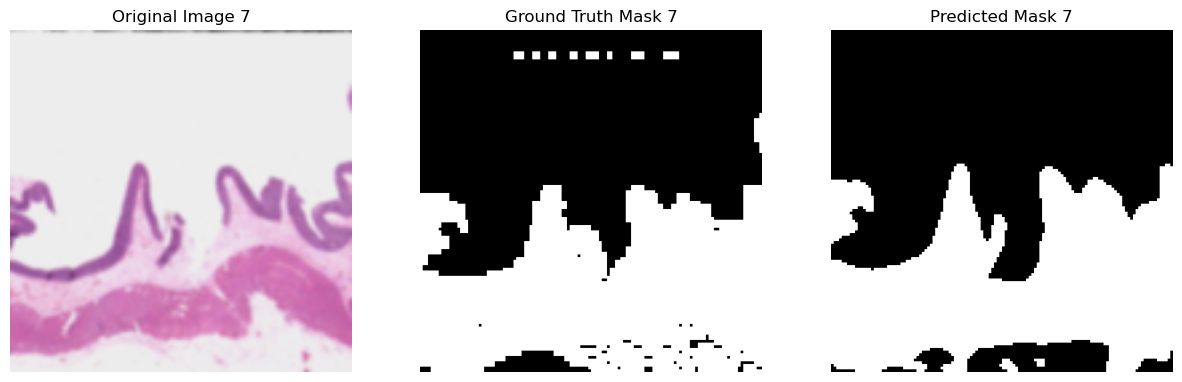

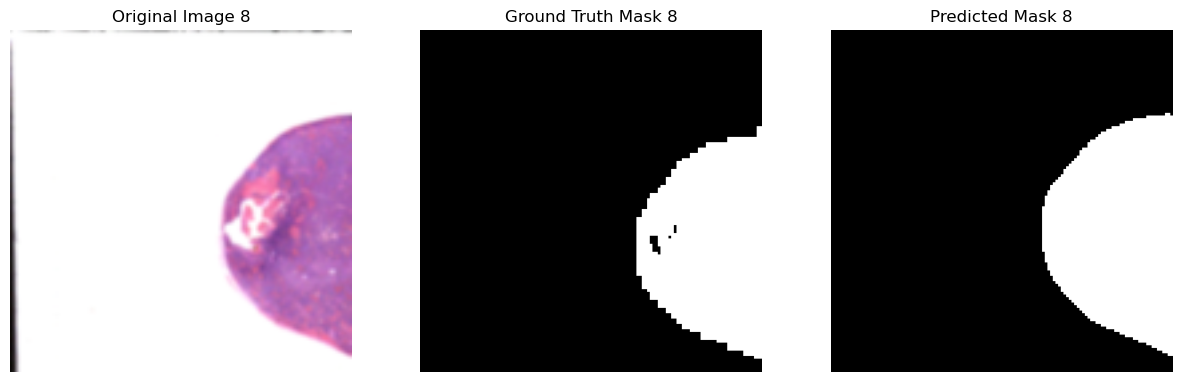

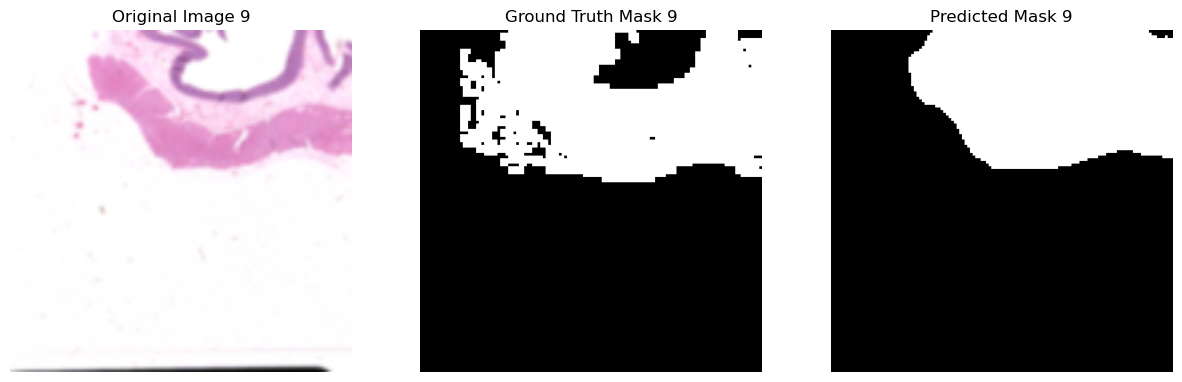

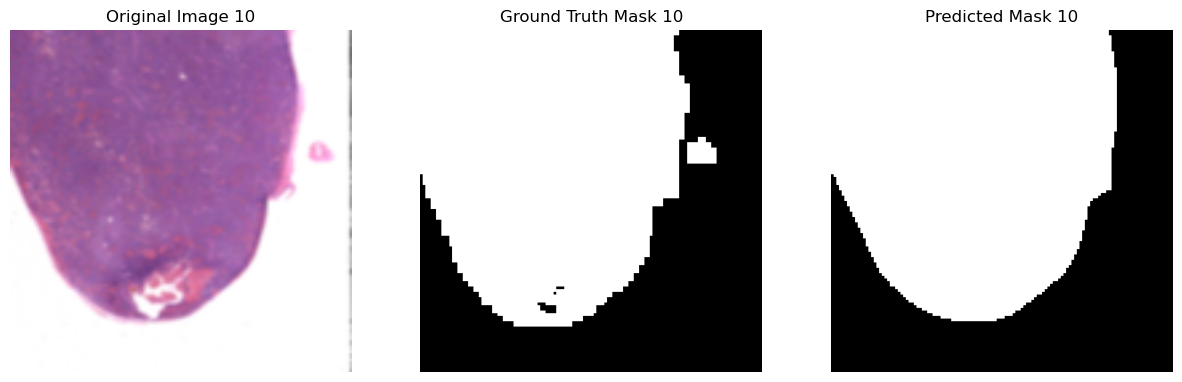

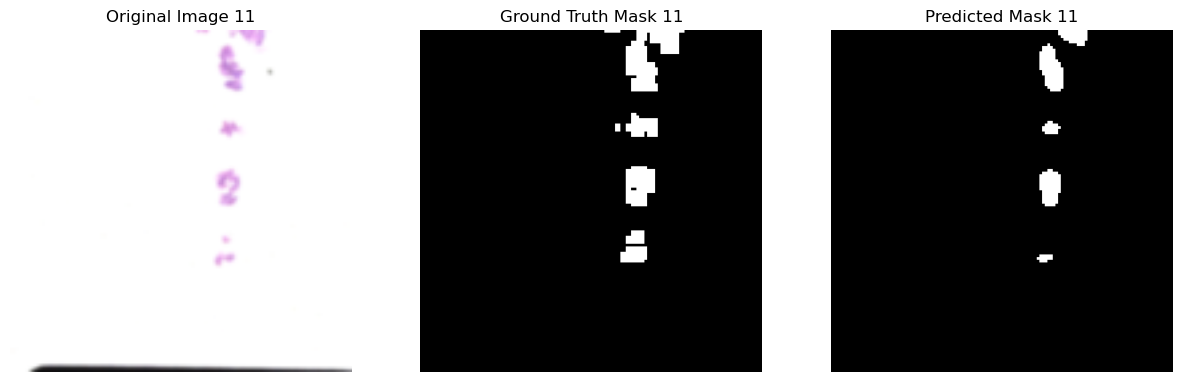

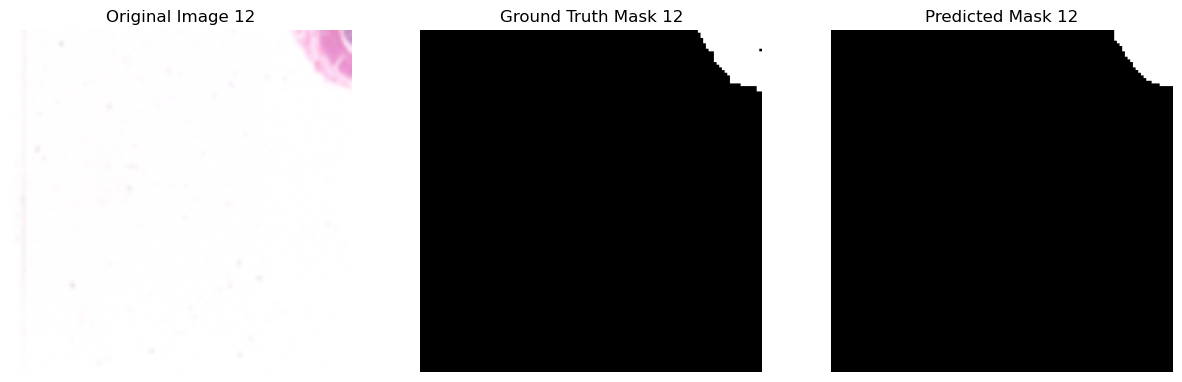

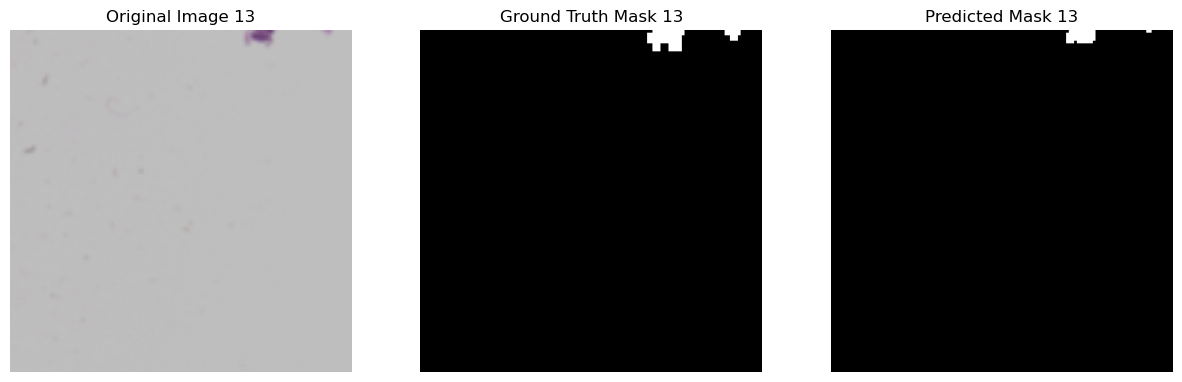

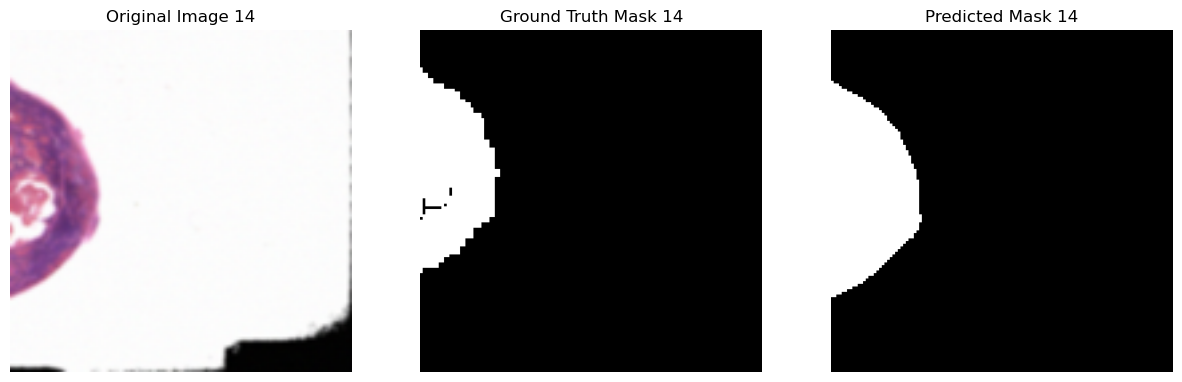

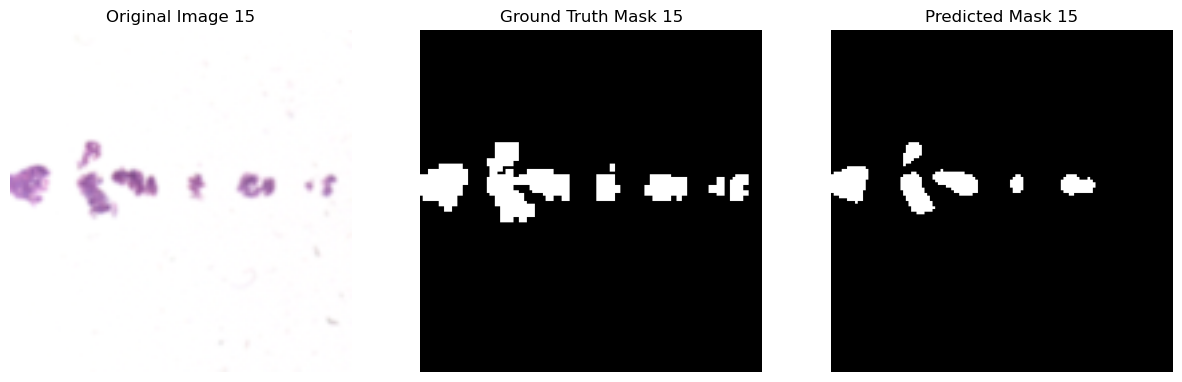

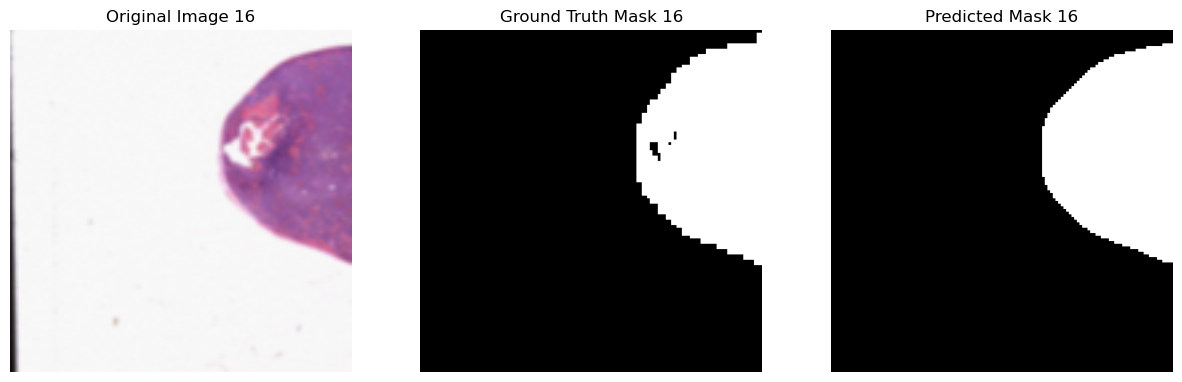

Inferencing:  20%|██        | 1/5 [00:12<00:48, 12.10s/it]

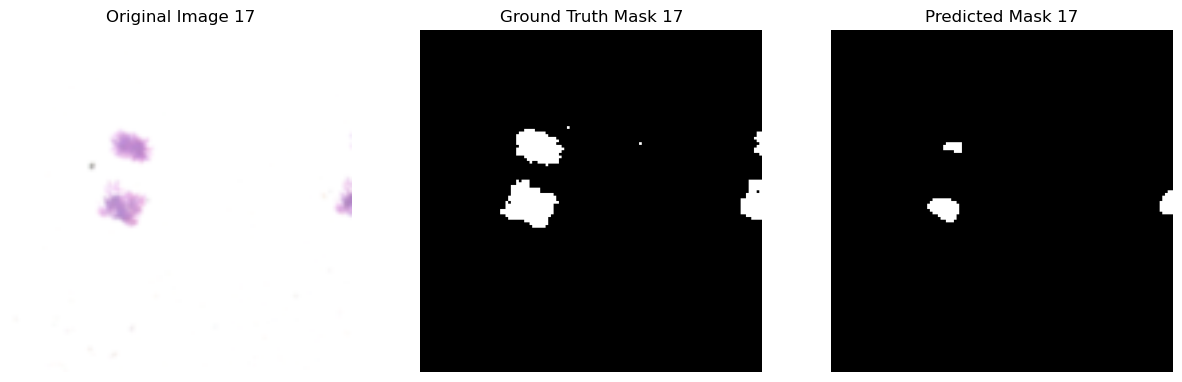

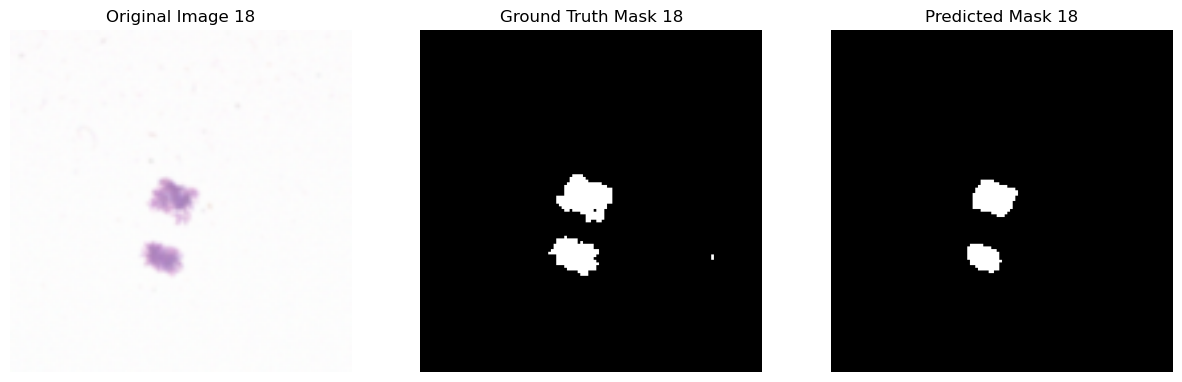

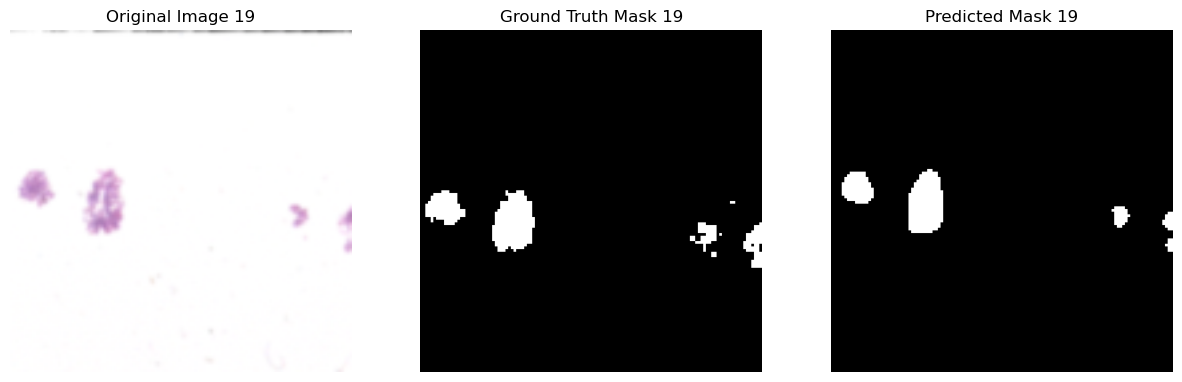

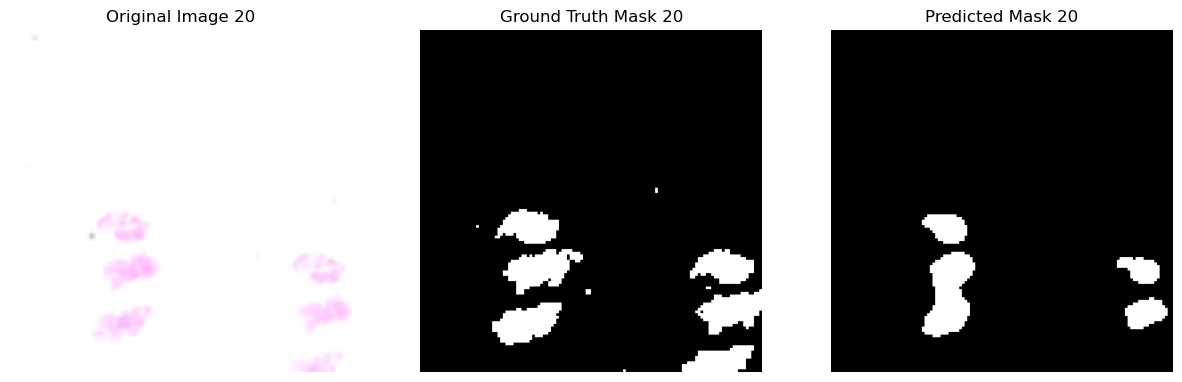

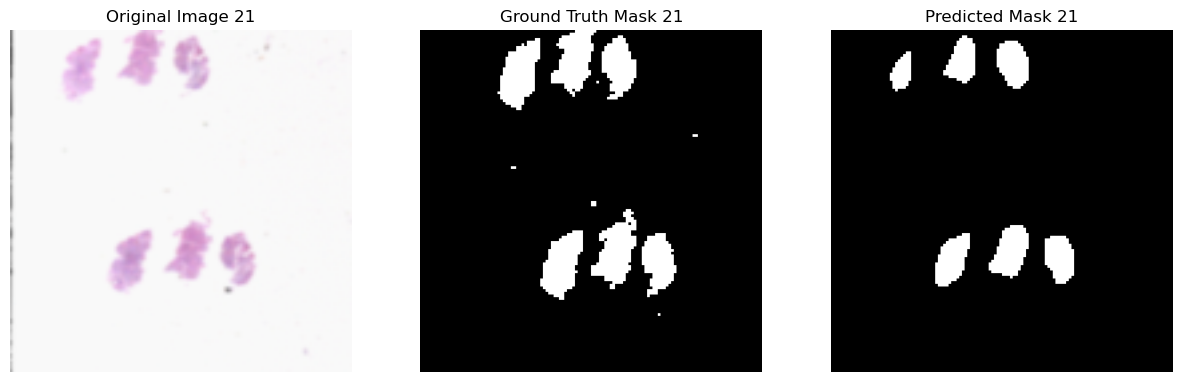

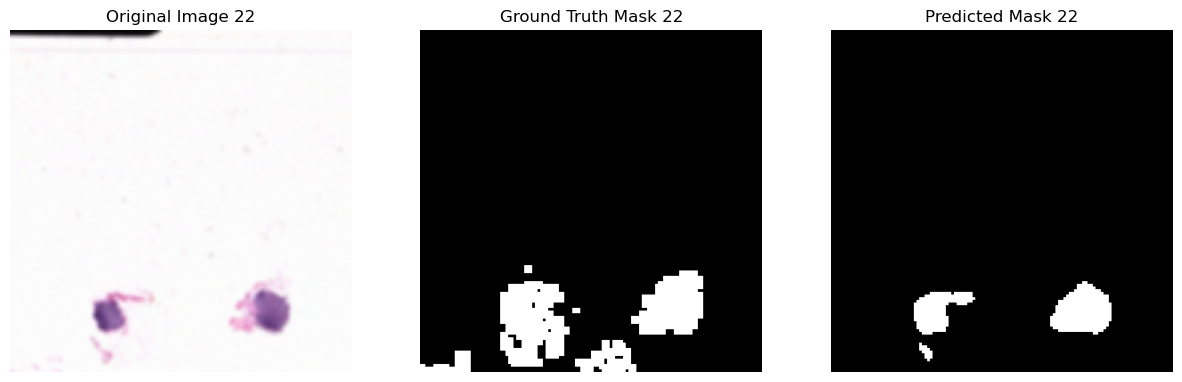

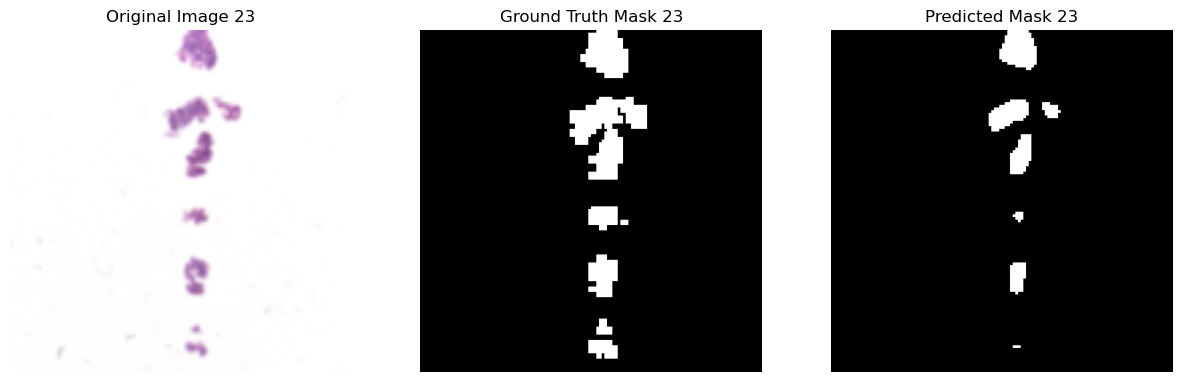

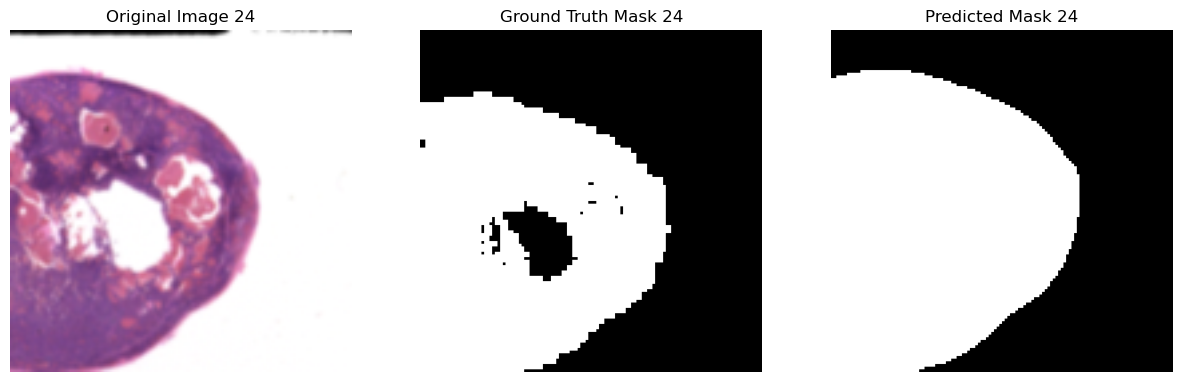

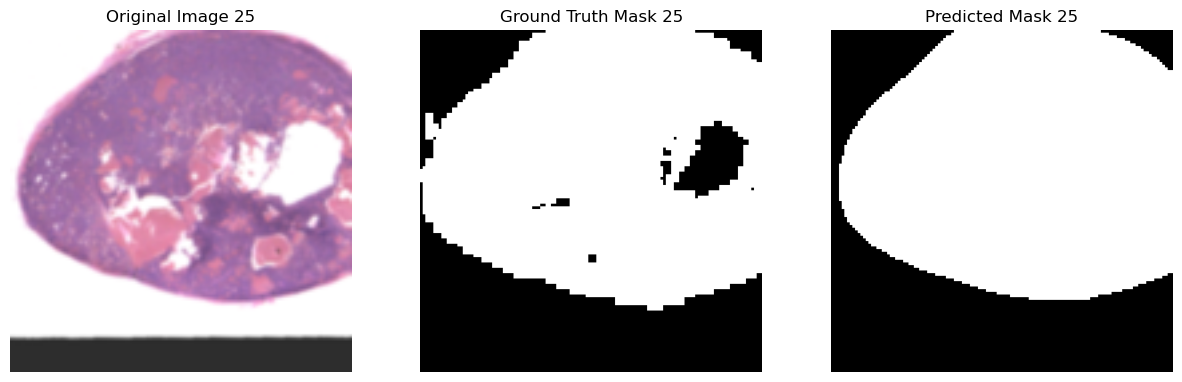

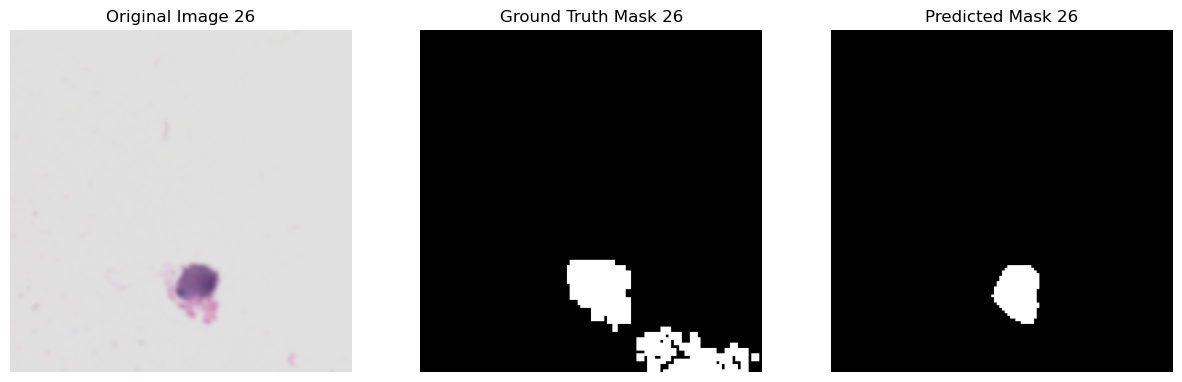

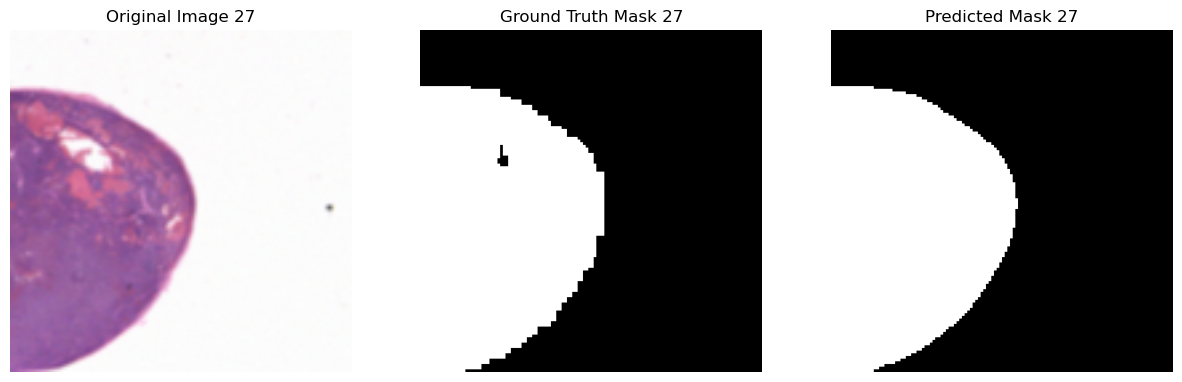

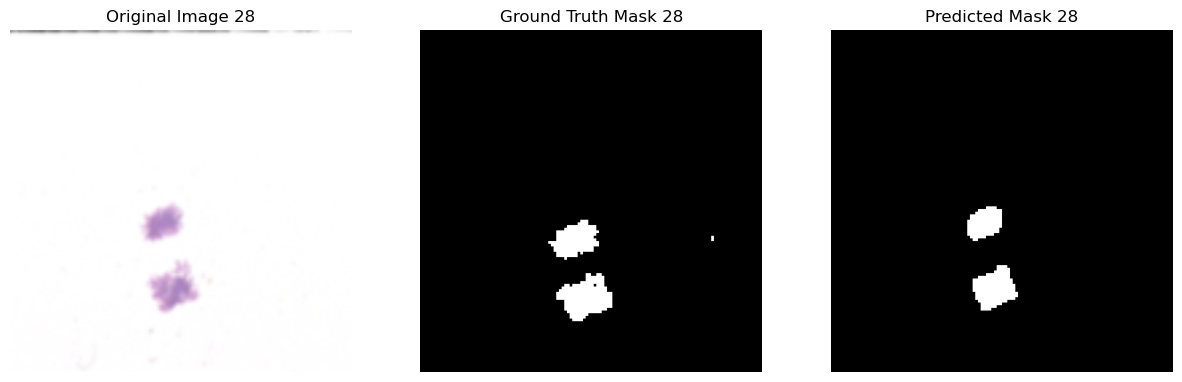

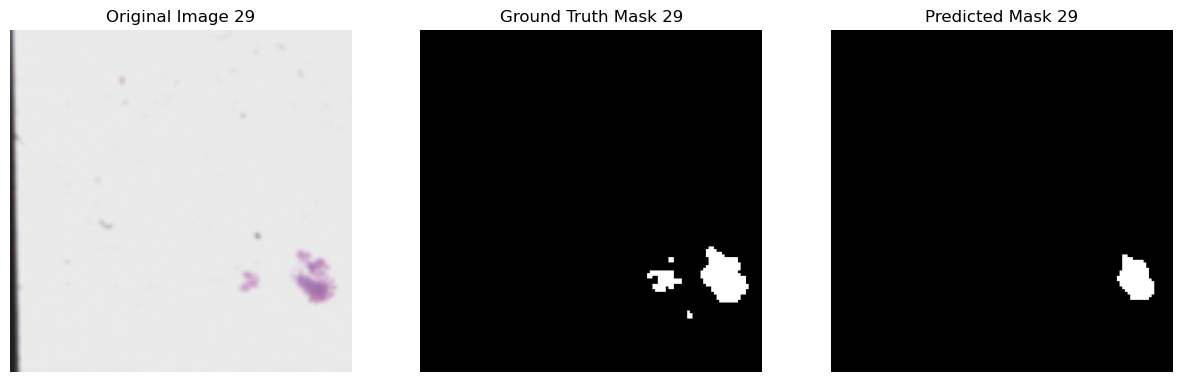

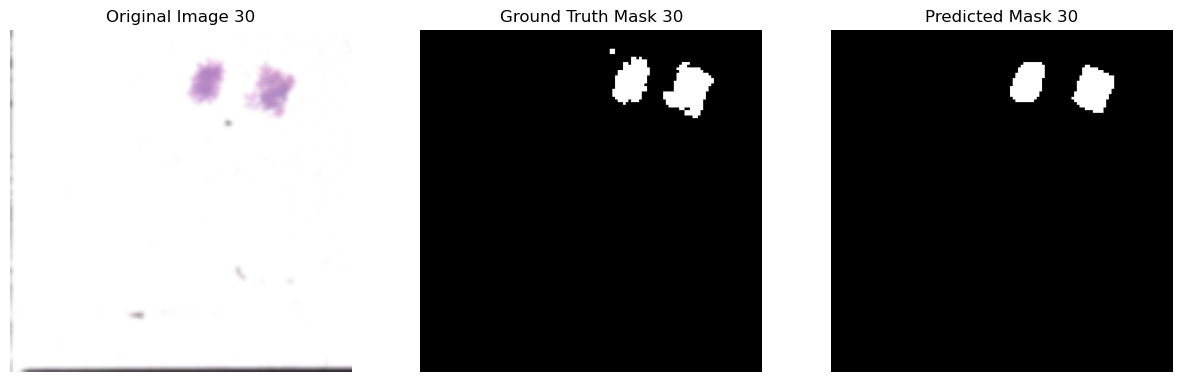

Inferencing:  20%|██        | 1/5 [00:23<01:32, 23.15s/it]


Mean IoU: 0.6542
Mean Dice: 0.7617


In [5]:
# Inference on the test set using inference.py

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device to be used
print(f"Device: {device}")

# Call the inference function
infer_and_display(
    model=model_test,
    image_processor=image_processor_test,
    dataloader=val_loader,
    device=device,
    num_samples=30,
    target_size=(256,256)
)


